In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [175]:
car_price_df = pd.read_csv("https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Car%20Price.csv");

In [176]:
car_price_df.head()

,Brand,Model,Year,Selling_Price,KM_Driven,Fuel,Seller_Type,Transmission,Owner
0,Maruti,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


### **Задача.** Выберите некоторое количество переменных для кластеризации

Для начала можно выбрать 2 переменных цену и пробег.

In [177]:
clustering_data = car_price_df[["Selling_Price", "KM_Driven"]].copy()

### **Задача** Разделите наблюдения на кластеры с помощью K-Means. Подберите оптимальное число кластеров. Подберите и постройте наиболее интересные визуализации для полученных кластеров, чтобы подчеркнуть их различия. Дайте бизнес-интерпретацию полученным кластерам. Как результат соотносится с целевой переменной, использованной в задаче классификации?

Пайплайн выглядит так, сначала нужно нормализовать все переменные прежде чем начать кластеризацию.

In [178]:
pipeline = Pipeline([("scaler", StandardScaler()), ("kmeans", KMeans(random_state=42))])

Подбор лучшего количества кластеров с помощью метода локтя.

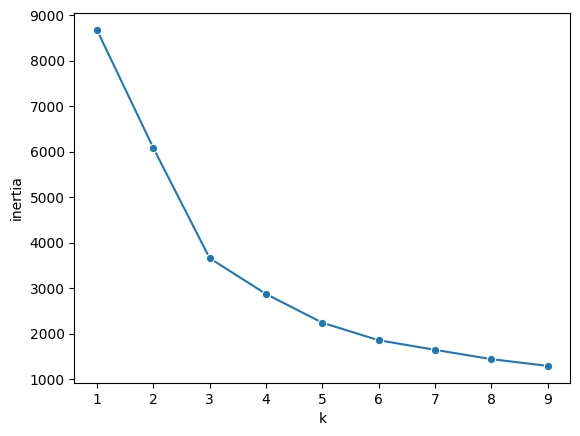

In [179]:
inertia = []
k_range = range(1, 10)

for k in k_range:
    pipeline.set_params(kmeans__n_clusters=k)
    pipeline.fit(clustering_data)
    inertia.append(pipeline.named_steps["kmeans"].inertia_)


df_elbow = pd.DataFrame({"k": list(k_range), "inertia": inertia})
sns.lineplot(data=df_elbow, x="k", y="inertia", marker="o")
plt.show()

На графике выше можно отметить резкое уменьшение падения суммы квадратов расстояний от точек до центров кластера - "локоть". Это и есть оптимальное количество кластеров - 3.

Разделение данных на кластеры

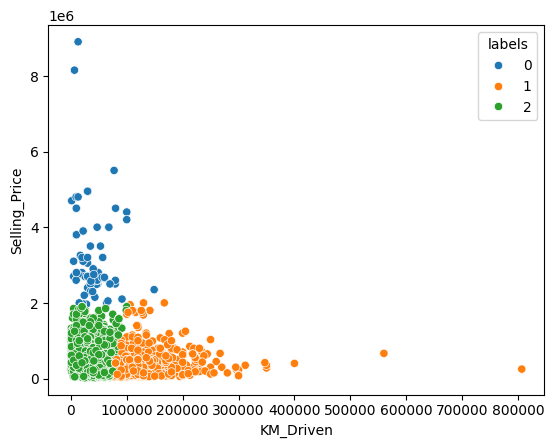

In [180]:
pipeline.set_params(kmeans__n_clusters=3)
pipeline.fit(clustering_data)
clustering_data["labels"] = pipeline.predict(clustering_data)
sns.scatterplot(clustering_data, x="KM_Driven", y="Selling_Price", hue="labels", palette="tab10")
plt.show()

k means кажется нормально разделил транспортные средства на кластеры. Один из кластеров - дорогие машины. Затем с адекватной ценой и с небольшим пробегом, третий кластер с адекватной ценой и большим пробегом.

Можно попробовать скомбинировать цену продажи с другой переменной - Year. 

In [181]:
clustering_data2 = car_price_df[["Selling_Price", "Year"]].copy()

Снова подбор наилучшего количества кластеров

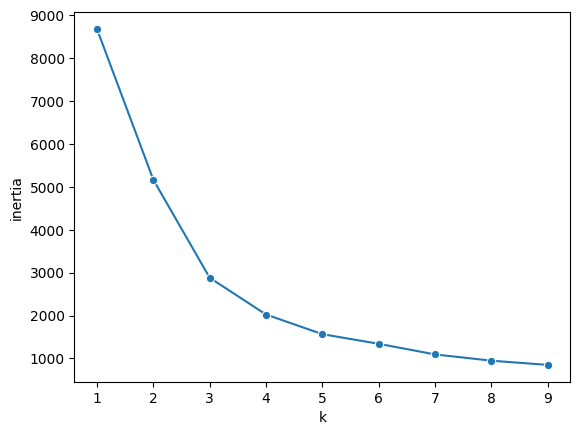

In [182]:
inertia = []
k_range = range(1, 10)

for k in k_range:
    pipeline.set_params(kmeans__n_clusters=k)
    pipeline.fit(clustering_data2)
    inertia.append(pipeline.named_steps["kmeans"].inertia_)


df_elbow = pd.DataFrame({"k": list(k_range), "inertia": inertia})
sns.lineplot(data=df_elbow, x="k", y="inertia", marker="o")
plt.show()

Ситуация аналогична первому кейсу, оптимальное количество кластеров - 3

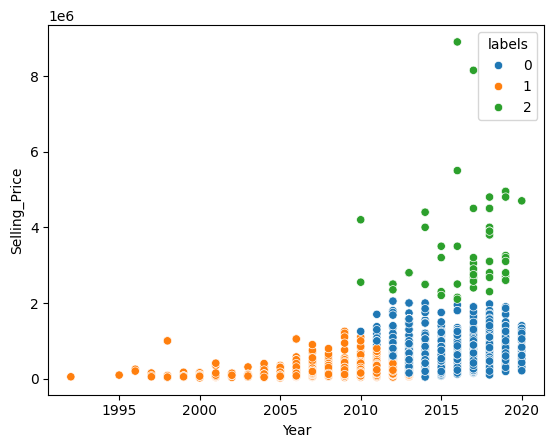

In [183]:
pipeline.set_params(kmeans__n_clusters=3)
pipeline.fit(clustering_data2)
clustering_data2["labels"] = pipeline.predict(clustering_data2)
sns.scatterplot(clustering_data2, x="Year", y="Selling_Price", hue="labels", palette="tab10")
plt.show()

Ситуация аналогична первому кейсу т. к год производства напрямую коррелирует с пробегом авто.

### **Задача** Разделите на кластеры с помощью иерархической кластеризации. Используйте разные правила группировки (расстояния между кластерами).

Подготовка данных

In [190]:
clustering_data = car_price_df[["Selling_Price", "KM_Driven"]].copy()

Для определения количества кластеров можно использовать дендрограммы

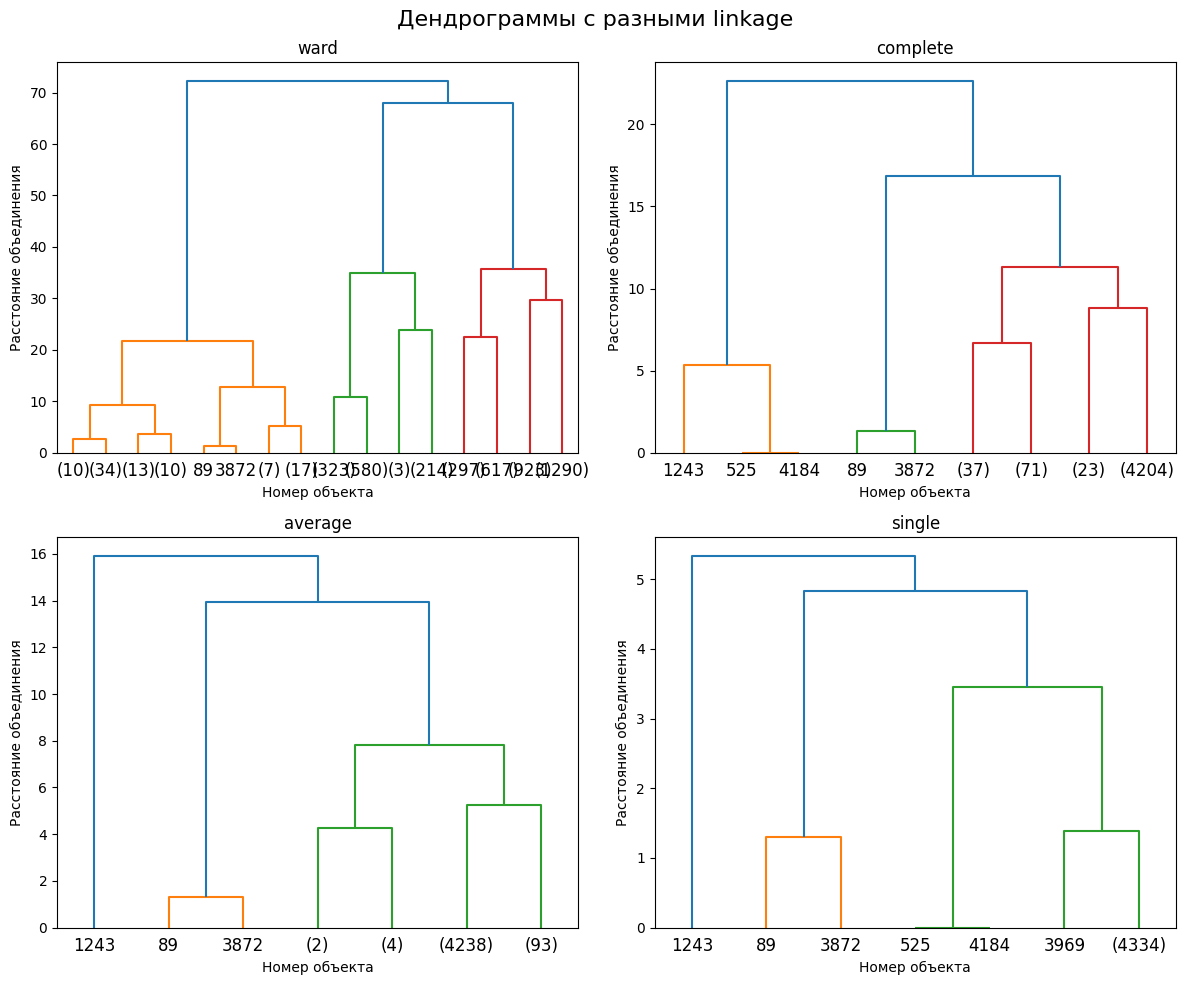

In [191]:
linkage_methods = ["ward", "complete", "average", "single"]
X_scaled = StandardScaler().fit_transform(clustering_data)

plt.figure(figsize=(12, 10))

for i, method in enumerate(linkage_methods, 1):
    Z = linkage(X_scaled, method=method)

    ax = plt.subplot(2, 2, i)
    dendrogram(Z, ax=ax, truncate_mode="level", p=3)
    plt.title(method)
    plt.xlabel("Номер объекта")
    plt.ylabel("Расстояние объединения")

plt.suptitle("Дендрограммы с разными linkage", fontsize=16)
plt.tight_layout()
plt.show()

На графике видно для разных методов количество кластеров одинаковое - 3

Аналогично для иерархической кластеризации необходимо провести нормализацию переменных.

In [192]:
pipeline = Pipeline([("scaler", StandardScaler()), ("agglo", AgglomerativeClustering(n_clusters=3))])

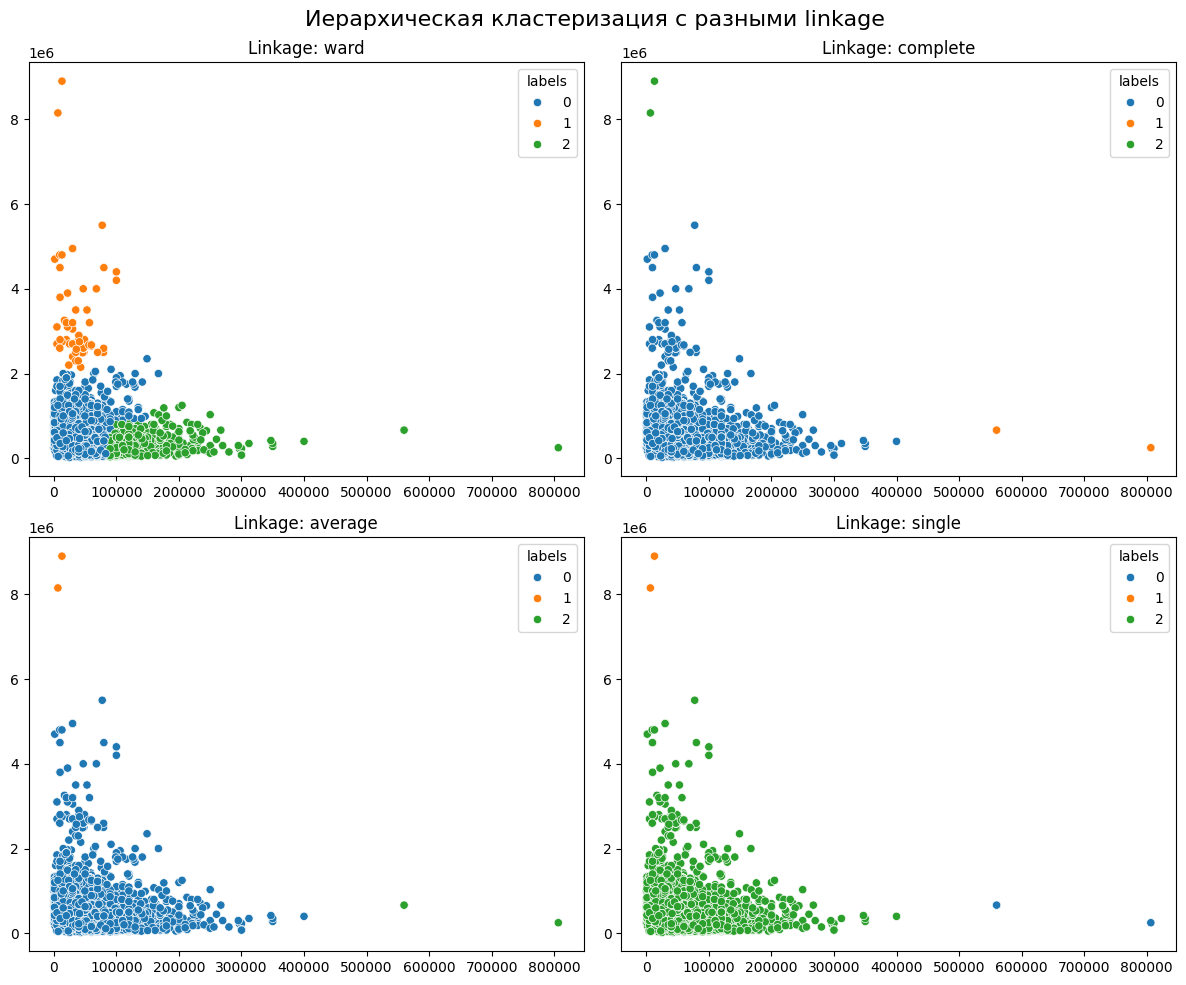

In [193]:
linkage_methods = ["ward", "complete", "average", "single"]

plt.figure(figsize=(12, 10))

for i, method in enumerate(linkage_methods, 1):
    model = pipeline.set_params(agglo__linkage=method)
    labels = model.fit_predict(clustering_data)
    clustering_data["labels"] = labels

    plt.subplot(2, 2, i)
    sns.scatterplot(clustering_data, x="KM_Driven", y="Selling_Price", hue="labels", palette="tab10")
    plt.title(f"Linkage: {method}")
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Иерархическая кластеризация с разными linkage", fontsize=16)
plt.tight_layout()
plt.show()

Метод Уорда показывает похожие результаты на kmeans кластеризацю. 
Остальные правила группировки объединили в кластер только сильные выбросы, которые состоят из небольшого количества значений, иногда это может быть полезным, например чтобы убрать эти выбросы.

Подготовка второй выборки

In [197]:
clustering_data2 = car_price_df[["Selling_Price", "Year"]].copy()

Дендрограммы для 2 выборки

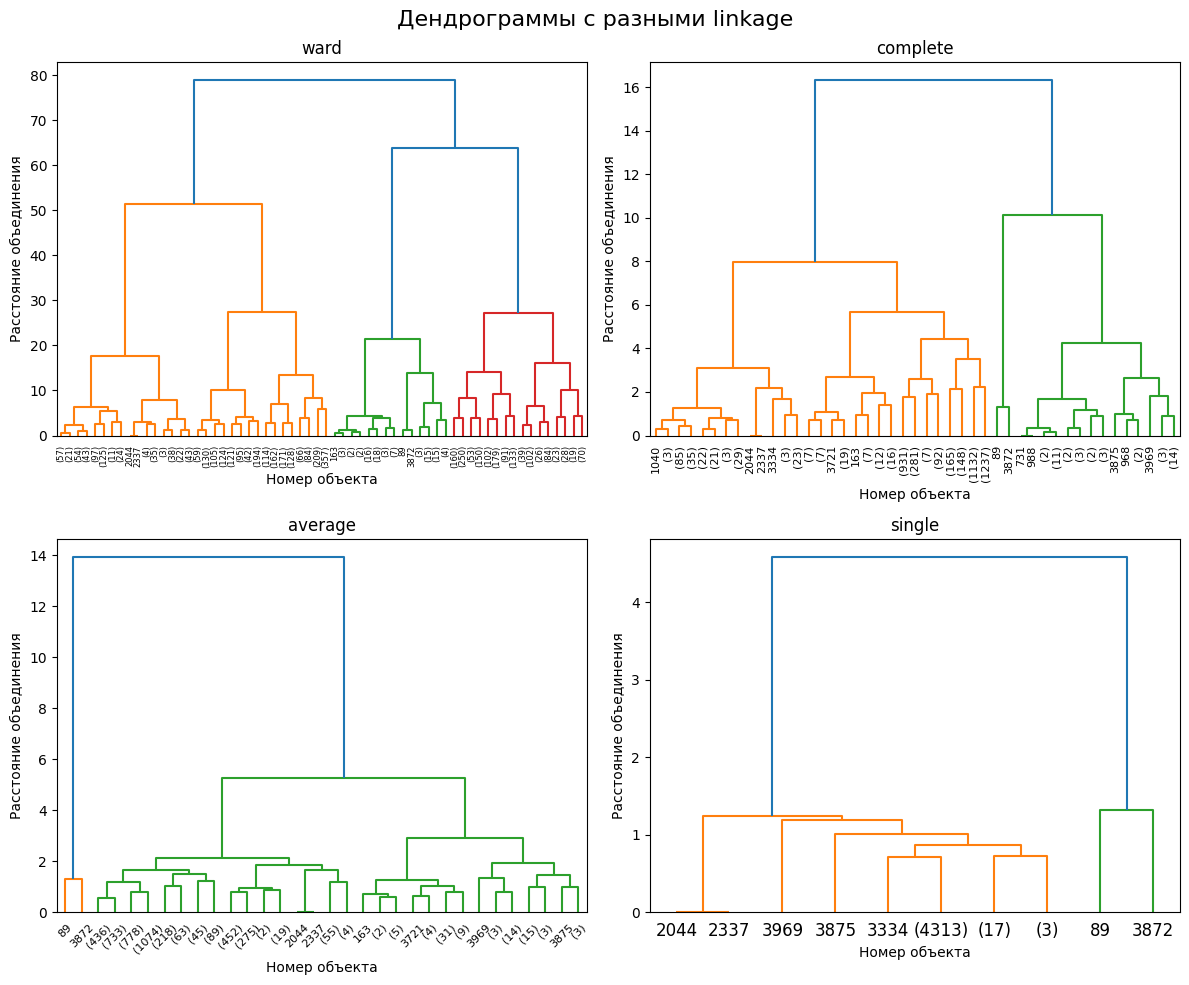

In [198]:
linkage_methods = ["ward", "complete", "average", "single"]
X_scaled = StandardScaler().fit_transform(clustering_data2)

plt.figure(figsize=(12, 10))

for i, method in enumerate(linkage_methods, 1):
    Z = linkage(X_scaled, method=method)

    ax = plt.subplot(2, 2, i)
    dendrogram(Z, ax=ax, truncate_mode="level", p=5)
    plt.title(method)
    plt.xlabel("Номер объекта")
    plt.ylabel("Расстояние объединения")

plt.suptitle("Дендрограммы с разными linkage", fontsize=16)
plt.tight_layout()
plt.show()

По дендрограммам видно что для разных типов группировки стоит выбрать разное количество кластеров, но при делении данных на 3 кластера результаты чуть интереснее.

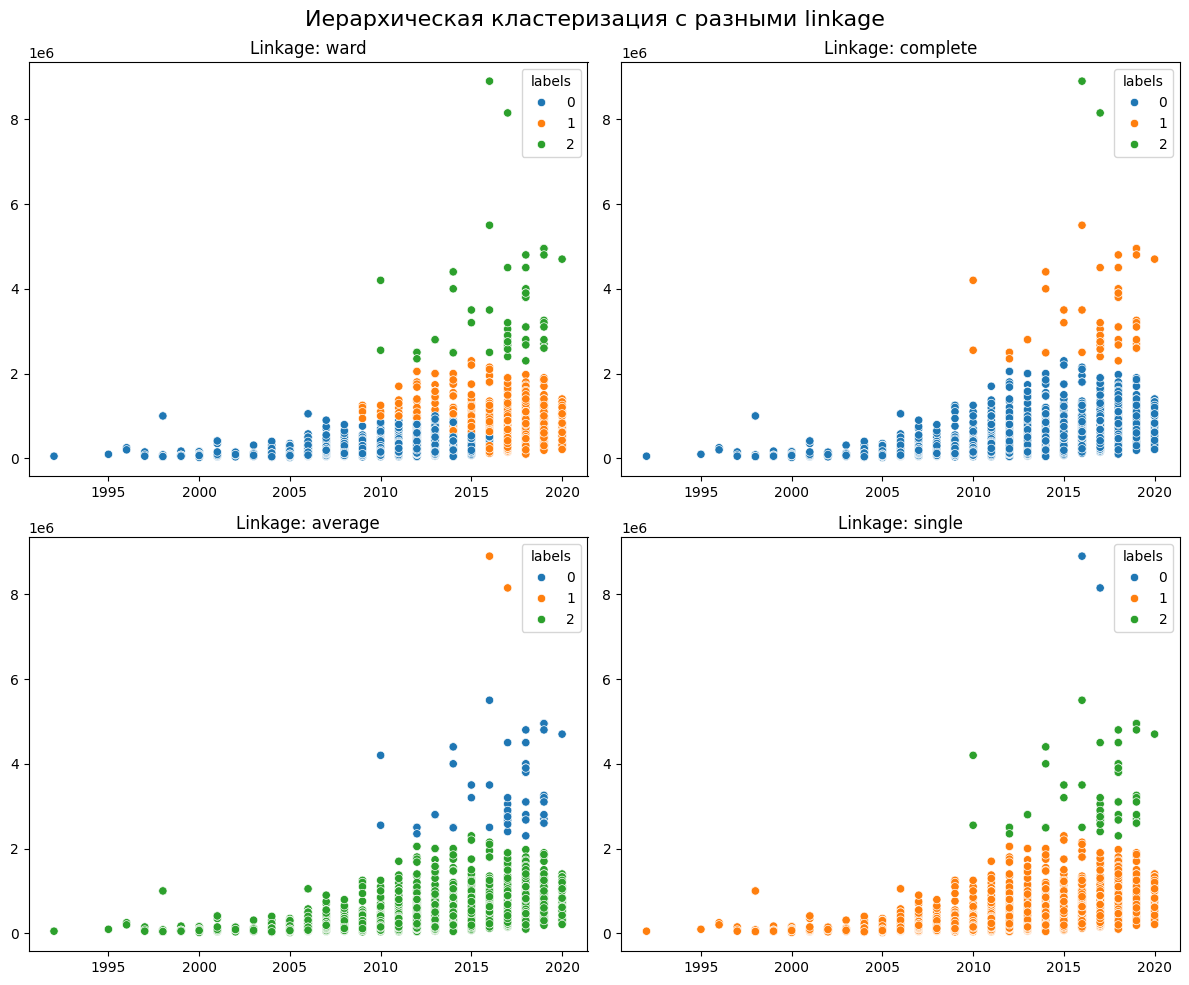

In [199]:
linkage_methods = ["ward", "complete", "average", "single"]

plt.figure(figsize=(12, 10))

for i, method in enumerate(linkage_methods, 1):
    model = pipeline.set_params(agglo__linkage=method)
    labels = model.fit_predict(clustering_data2)
    clustering_data2["labels"] = labels

    plt.subplot(2, 2, i)
    sns.scatterplot(clustering_data2, x="Year", y="Selling_Price", hue="labels", palette="tab10")
    plt.title(f"Linkage: {method}")
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Иерархическая кластеризация с разными linkage", fontsize=16)
plt.tight_layout()
plt.show()

На этих данных ситуация интереснее - метод Уорда все также похож на kmeans. А остальные методы поделили авто на 3 кластера по цене. Один из кластеров представляет обычные среднестатистические ТС. Второй кластер возможно премиум сегмент. А третий - очень дорогие, супер кары итд.

### **Задача** Сравните результаты кластеризации.

Для данных зависимости пробега и цены методы иерархической кластеризации могут помочь удалить какие то очень сильные выбросы, а с использованием правила группировки Уорда результат кластеризации почти такой же как с kmeans.

На данных зависимости года выпуска и цены иерархическая кластеризация дала весьма интересное представление данных позволив разделить их по цене на сегменты.